0.01990199089050293
0.04642367362976074
0.04616093635559082
0.05646371841430664
0.023764610290527344


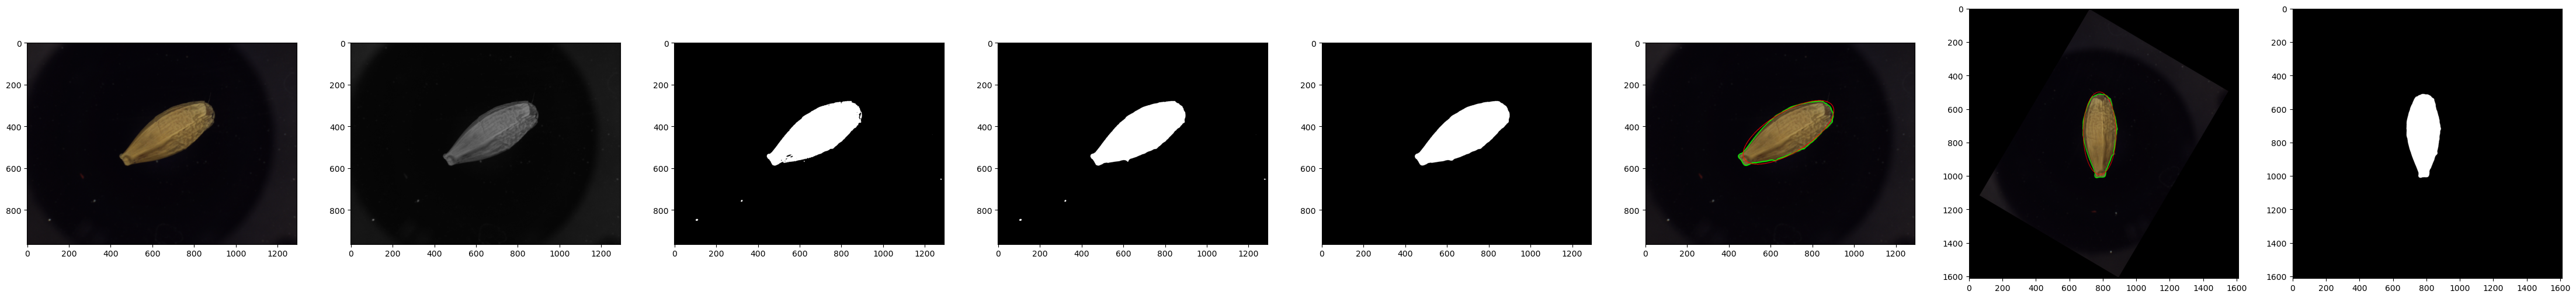

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        print('gray')
        plt.imshow(image_src, cmap='gray')
    plt.show()

def show_plt_results(image_mat=None, size=2, columns=0):
    """
    Funkcja wyświetla listę obrazów

    Args:
        image_mat (list): Lista obrazów
        size (int): wielkość wyświetlanego matplotlib
        columns (int): liczba kolumn. 0 = liczba kolumn jest równa liczbie elementów listy image_mat
    """
    if image_mat is None:
        image_mat = []

    if columns == 0:
        columns = len(image_mat)
    rows = (len(image_mat) + columns - 1) // columns

    fig = plt.figure(figsize=(size * columns, size * rows))
    for i in range(1, len(image_mat) + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(cv2.cvtColor(image_mat[i - 1], cv2.COLOR_BGR2RGB))
    plt.show()

# Kolorowy obraz
path_to_image = '/media/4TB/datasets/DATASET/basil/30562_B.png'
image_list = []

image = cv2.imread(path_to_image)
image_list.append(image)

# Odcienie szarości
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_list.append(image_gray)

# Maska binarna
_, mask_binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
image_list.append(mask_binary)

# Mediana maski
start = time.time()
mask_binary_median = cv2.medianBlur(mask_binary, 41)
print(time.time() - start)

# Otwarcie + Zamknięcie
def morphology_operations(src, morph_operator=1, morph_size=13, val_type=2):
    """
    morph_operator = 1  #'Operator:\n 0: Opening - 1: Closing  \n 2: Gradient - 3: Top Hat \n 4: Black Hat'
    morph_size = 13 #'Kernel size:\n 2n + 1'
    val_type = 2  #'Element:\n 0: Rect - 1: Cross - 2: Ellipse'
    """
    morph_elem = cv2.MORPH_RECT if val_type == 0 else cv2.MORPH_CROSS if val_type == 1 else cv2.MORPH_ELLIPSE
    element = cv2.getStructuringElement(morph_elem, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    operation = {0: cv2.MORPH_OPEN, 1: cv2.MORPH_CLOSE, 2: cv2.MORPH_GRADIENT, 3: cv2.MORPH_TOPHAT, 4: cv2.MORPH_BLACKHAT}[morph_operator]
    return cv2.morphologyEx(src, operation, element)

start = time.time()
mask_binary_open_close = morphology_operations(mask_binary, morph_operator=0)
mask_binary_open_close = morphology_operations(mask_binary_open_close, morph_operator=1)
print(time.time() - start)

start = time.time()
mask_binary_close_open = morphology_operations(mask_binary, morph_operator=1)
mask_binary_close_open = morphology_operations(mask_binary_close_open, morph_operator=0)
print(time.time() - start)

# CLOSE
start = time.time()
mask_binary_close = morphology_operations(mask_binary, morph_operator=1, morph_size=21)
print(time.time() - start)
image_list.append(mask_binary_close)

# Otwarcie
start = time.time()
mask_binary_open = morphology_operations(mask_binary_close, morph_operator=0, morph_size=13)
print(time.time() - start)
image_list.append(mask_binary_open)

# Bilateral Filter
sigma = 200
bi_ksize = 81
mask_binary_bilateral = cv2.bilateralFilter(mask_binary, bi_ksize, sigma, sigma)

# Kontury
contours, hierarchy = cv2.findContours(mask_binary_open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image2 = image.copy()
largest_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(image2, [largest_contour], -1, (0, 255, 0), 3)
min_ellipse = cv2.fitEllipse(largest_contour)
cv2.ellipse(image2, min_ellipse, (0, 0, 255), 2)

# Obliczanie macierzy rotacji
height, width = image2.shape[:2]
center = (width // 2, height // 2)
angle = min_ellipse[2]
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Obliczanie nowych wymiarów obrazu
new_width = int(np.sqrt(width**2 + height**2))
new_height = new_width

# Obliczanie przesunięcia, aby umieścić obrócony obraz w centrum nowego obrazu
tx = (new_width - width) // 2
ty = (new_height - height) // 2
rotation_matrix[0, 2] += tx
rotation_matrix[1, 2] += ty

# Obracanie obrazów
rotated_image = cv2.warpAffine(image2, rotation_matrix, (new_width, new_height))
rotated_mask = cv2.warpAffine(mask_binary_open, rotation_matrix, (new_width, new_height))

image_list.append(image2)
image_list.append(rotated_image)
image_list.append(rotated_mask)

show_plt_results(image_list, size=7, columns=0)

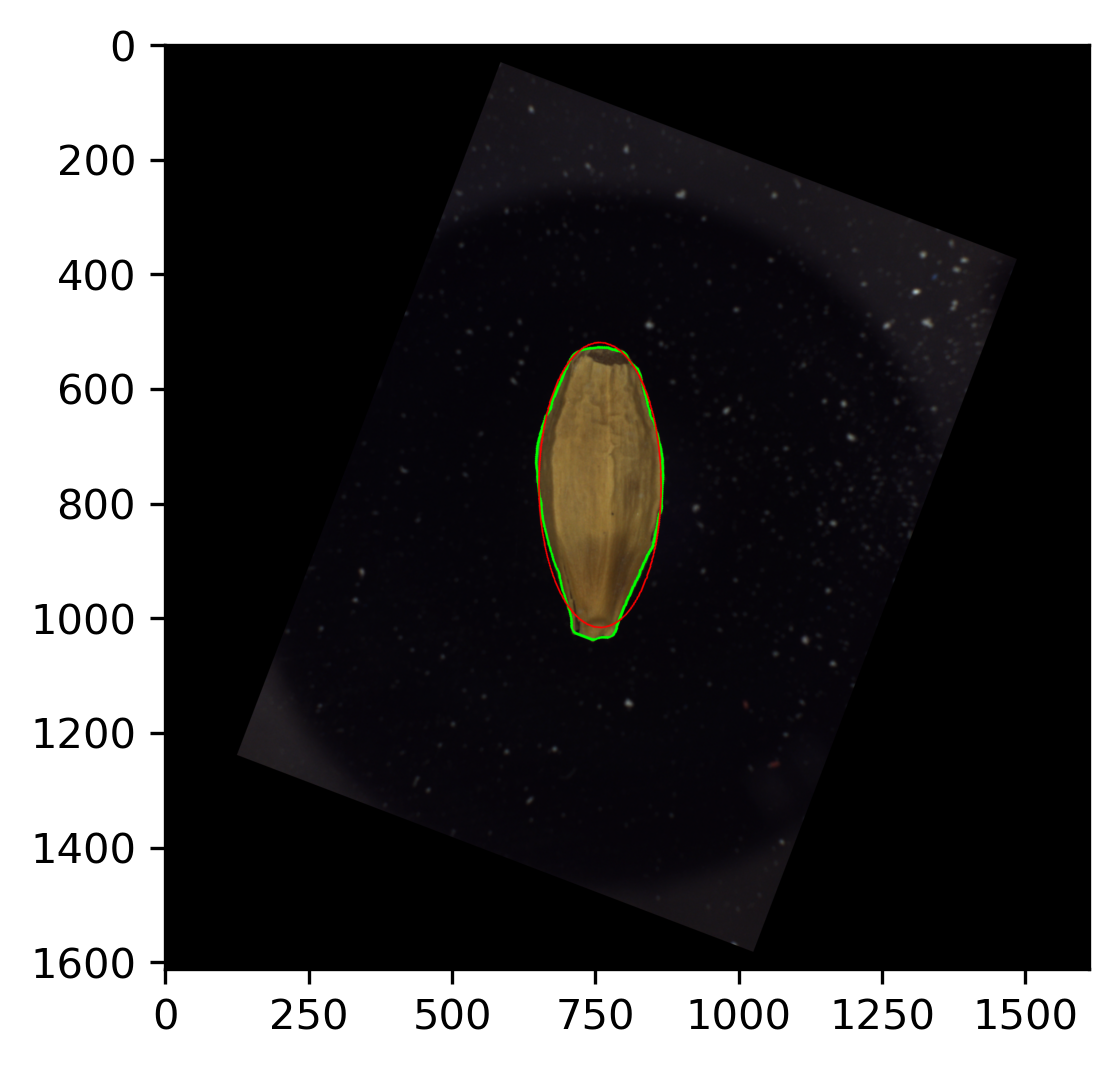

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        print('gray')
        plt.imshow(image_src, cmap='gray')
    plt.show()

def morphology_operations(src, morph_operator=1, morph_size=13, val_type=2):
    """
    morph_operator = 1  #'Operator:\n 0: Opening - 1: Closing  \n 2: Gradient - 3: Top Hat \n 4: Black Hat'
    morph_size = 13 #'Kernel size:\n 2n + 1'
    val_type = 2  #'Element:\n 0: Rect - 1: Cross - 2: Ellipse'
    """
    morph_elem = cv2.MORPH_RECT if val_type == 0 else cv2.MORPH_CROSS if val_type == 1 else cv2.MORPH_ELLIPSE
    element = cv2.getStructuringElement(morph_elem, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    operation = {0: cv2.MORPH_OPEN, 1: cv2.MORPH_CLOSE, 2: cv2.MORPH_GRADIENT, 3: cv2.MORPH_TOPHAT, 4: cv2.MORPH_BLACKHAT}[morph_operator]
    return cv2.morphologyEx(src, operation, element)

# Kolorowy obraz
path_to_image = '/media/4TB/datasets/DATASET/basil/32826_B.png'
image = cv2.imread(path_to_image)

# Odcienie szarości
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Maska binarna
_, mask_binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Otwarcie + Zamknięcie
mask_binary_open_close = morphology_operations(mask_binary, morph_operator=0)
mask_binary_open_close = morphology_operations(mask_binary_open_close, morph_operator=1)

# CLOSE
mask_binary_close = morphology_operations(mask_binary, morph_operator=1, morph_size=21)

# Otwarcie
mask_binary_open = morphology_operations(mask_binary_close, morph_operator=0, morph_size=13)

# Kontury
contours, hierarchy = cv2.findContours(mask_binary_open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image2 = image.copy()
largest_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(image2, [largest_contour], -1, (0, 255, 0), 3)
min_ellipse = cv2.fitEllipse(largest_contour)
cv2.ellipse(image2, min_ellipse, (0, 0, 255), 2)

# Obliczanie macierzy rotacji
height, width = image2.shape[:2]
center = (width // 2, height // 2)
angle = min_ellipse[2]
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Obliczanie nowych wymiarów obrazu
new_width = int(np.sqrt(width**2 + height**2))
new_height = new_width

# Obliczanie przesunięcia, aby umieścić obrócony obraz w centrum nowego obrazu
tx = (new_width - width) // 2
ty = (new_height - height) // 2
rotation_matrix[0, 2] += tx
rotation_matrix[1, 2] += ty

# Obracanie obrazów
rotated_image = cv2.warpAffine(image2, rotation_matrix, (new_width, new_height))

# Wyświetlanie obróconego obrazu
show(rotated_image)

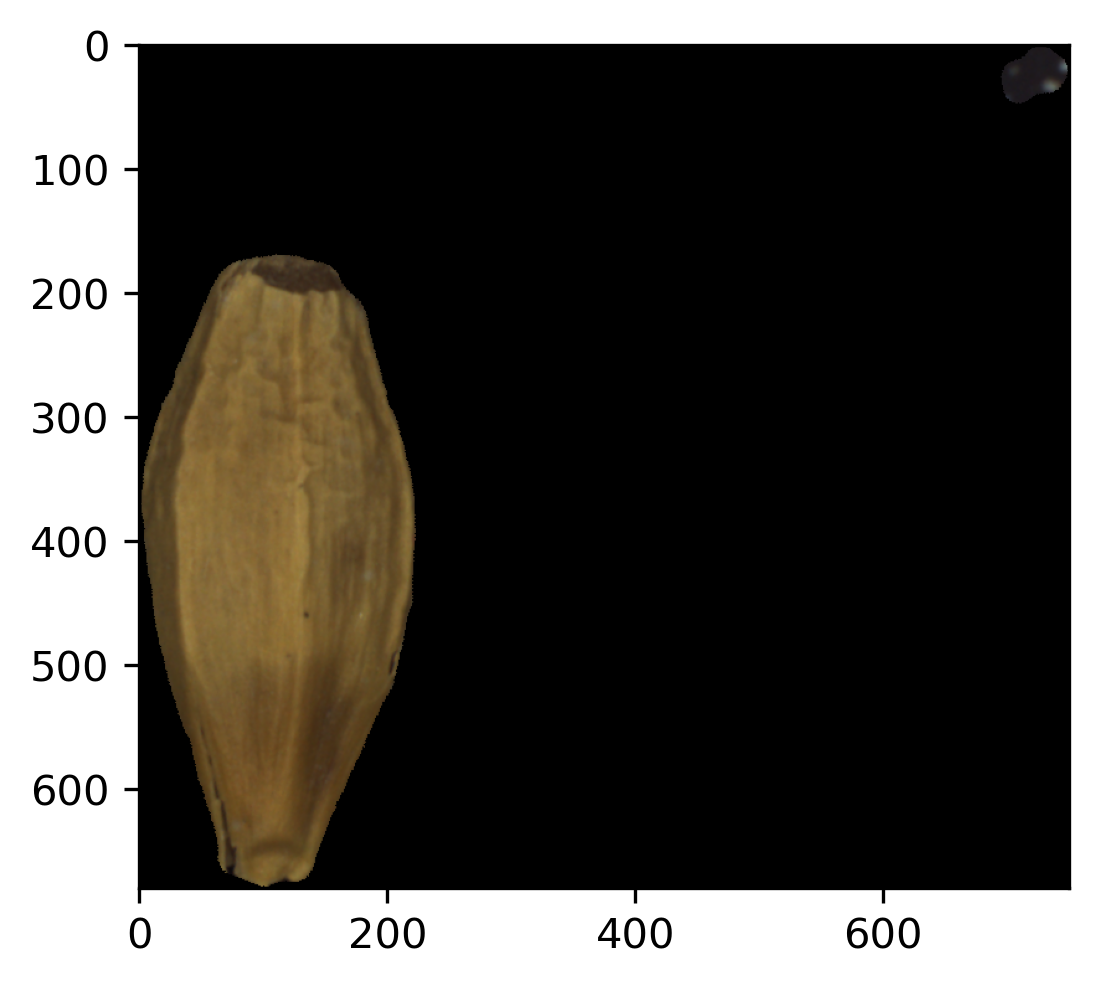

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        print('gray')
        plt.imshow(image_src, cmap='gray')
    plt.show()

def morphology_operations(src, morph_operator=1, morph_size=13, val_type=2):
    """
    morph_operator = 1  #'Operator:\n 0: Opening - 1: Closing  \n 2: Gradient - 3: Top Hat \n 4: Black Hat'
    morph_size = 13 #'Kernel size:\n 2n + 1'
    val_type = 2  #'Element:\n 0: Rect - 1: Cross - 2: Ellipse'
    """
    morph_elem = cv2.MORPH_RECT if val_type == 0 else cv2.MORPH_CROSS if val_type == 1 else cv2.MORPH_ELLIPSE
    element = cv2.getStructuringElement(morph_elem, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    operation = {0: cv2.MORPH_OPEN, 1: cv2.MORPH_CLOSE, 2: cv2.MORPH_GRADIENT, 3: cv2.MORPH_TOPHAT, 4: cv2.MORPH_BLACKHAT}[morph_operator]
    return cv2.morphologyEx(src, operation, element)

# Kolorowy obraz
path_to_image = '/media/4TB/datasets/DATASET/basil/32826_B.png'
image = cv2.imread(path_to_image)

# Odcienie szarości
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Maska binarna
_, mask_binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Otwarcie + Zamknięcie
mask_binary_open_close = morphology_operations(mask_binary, morph_operator=0)
mask_binary_open_close = morphology_operations(mask_binary_open_close, morph_operator=1)

# CLOSE
mask_binary_close = morphology_operations(mask_binary, morph_operator=1, morph_size=21)

# Otwarcie
mask_binary_open = morphology_operations(mask_binary_close, morph_operator=0, morph_size=13)

# Kontury
contours, hierarchy = cv2.findContours(mask_binary_open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
min_ellipse = cv2.fitEllipse(largest_contour)

# Obliczanie macierzy rotacji
height, width = image.shape[:2]
center = (width // 2, height // 2)
angle = min_ellipse[2]
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Obracanie maski
rotated_mask = cv2.warpAffine(mask_binary_open, rotation_matrix, (width, height))

# Tworzenie czarnego obrazu o tych samych wymiarach co oryginalny obraz
rotated_image = np.zeros_like(image)

# Nakładanie obszaru zainteresowania na czarny obraz
for i in range(3):  # Dla każdego kanału (B, G, R)
    rotated_image[:, :, i] = cv2.warpAffine(image[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

# Znajdowanie bounding box dla obróconej maski
x, y, w, h = cv2.boundingRect(rotated_mask)

# Przycinanie obrazu do bounding box
cropped_image = rotated_image[y:y+h, x:x+w]

# Wyświetlanie przyciętego obrazu
show(cropped_image)

In [4]:
import cv2
import numpy as np
import os
import glob
import csv
import gc
from concurrent.futures import ProcessPoolExecutor, as_completed

def morphology_operations(src, morph_operator=1, morph_size=13, val_type=2):
    """
    morph_operator = 1  #'Operator:\n 0: Opening - 1: Closing  \n 2: Gradient - 3: Top Hat \n 4: Black Hat'
    morph_size = 13 #'Kernel size:\n 2n + 1'
    val_type = 2  #'Element:\n 0: Rect - 1: Cross - 2: Ellipse'
    """
    morph_elem = cv2.MORPH_RECT if val_type == 0 else cv2.MORPH_CROSS if val_type == 1 else cv2.MORPH_ELLIPSE
    element = cv2.getStructuringElement(morph_elem, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    operation = {0: cv2.MORPH_OPEN, 1: cv2.MORPH_CLOSE, 2: cv2.MORPH_GRADIENT, 3: cv2.MORPH_TOPHAT, 4: cv2.MORPH_BLACKHAT}[morph_operator]
    return cv2.morphologyEx(src, operation, element)

def process_image(path_to_image):
    image = cv2.imread(path_to_image)

    # Odcienie szarości
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Maska binarna
    _, mask_binary = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Otwarcie + Zamknięcie
    mask_binary_open_close = morphology_operations(mask_binary, morph_operator=0)
    mask_binary_open_close = morphology_operations(mask_binary_open_close, morph_operator=1)

    # CLOSE
    mask_binary_close = morphology_operations(mask_binary, morph_operator=1, morph_size=21)

    # Otwarcie
    mask_binary_open = morphology_operations(mask_binary_close, morph_operator=0, morph_size=13)

    # Kontury
    contours, hierarchy = cv2.findContours(mask_binary_open, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    min_ellipse = cv2.fitEllipse(largest_contour)

    # Obliczanie macierzy rotacji
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Obracanie maski największego konturu
    mask_largest_contour = np.zeros_like(mask_binary_open)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    # Tworzenie czarnego obrazu o tych samych wymiarach co oryginalny obraz
    rotated_image = np.zeros_like(image)

    # Nakładanie obszaru zainteresowania na czarny obraz
    for i in range(3):  # Dla każdego kanału (B, G, R)
        rotated_image[:, :, i] = cv2.warpAffine(image[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

    # Znajdowanie bounding box dla obróconej maski największego konturu
    x, y, w, h = cv2.boundingRect(rotated_mask)

    # Przycinanie obrazu do bounding box
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, os.path.dirname(path_to_image), os.path.basename(path_to_image)

def main(directory):
    # Znajdowanie wszystkich plików pasujących do wzorca <numer>_B.png
    image_paths = glob.glob(os.path.join(directory, '**', '*_B.png'), recursive=True)
    total_images = len(image_paths)
    processed_images = []
    widths = []
    heights = []

    with open('sizes_of_kernels.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Directory', 'Filename', 'Width', 'Height'])

        with ProcessPoolExecutor() as executor:
            futures = [executor.submit(process_image, path) for path in image_paths]
            previous_progress = -1
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result is not None:
                    cropped_image, width, height, dir_name, file_name = result
                    processed_images.append(cropped_image)
                    widths.append(width)
                    heights.append(height)
                    writer.writerow([dir_name, file_name, width, height])
                    # Zwalnianie pamięci
                    del cropped_image
                    gc.collect()
                # Wyświetlanie postępu
                current_progress = int(((i + 1) / total_images) * 100)
                if current_progress > previous_progress:
                    print(f'Progress: {current_progress}% {i+1}/{total_images}')
                    previous_progress = current_progress

In [ ]:
main("/media/4TB/datasets/DATASET/")

In [5]:
import cv2
import numpy as np
import os
import glob
import csv
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        print('gray')
        plt.imshow(image_src, cmap='gray')
    plt.show()

def morphology_operations(src, morph_operator=1, morph_size=13, val_type=2):
    morph_elem = cv2.MORPH_RECT if val_type == 0 else cv2.MORPH_CROSS if val_type == 1 else cv2.MORPH_ELLIPSE
    element = cv2.getStructuringElement(morph_elem, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    operation = {0: cv2.MORPH_OPEN, 1: cv2.MORPH_CLOSE, 2: cv2.MORPH_GRADIENT, 3: cv2.MORPH_TOPHAT, 4: cv2.MORPH_BLACKHAT}[morph_operator]
    return cv2.morphologyEx(src, operation, element)

def process_image(path_to_image):
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    _, mask_binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    mask_binary = morphology_operations(mask_binary, morph_operator=0)
    mask_binary = morphology_operations(mask_binary, morph_operator=1)
    
    mask_binary = morphology_operations(mask_binary, morph_operator=1, morph_size=21)
    mask_binary = morphology_operations(mask_binary, morph_operator=0, morph_size=13)

    contours, _ = cv2.findContours(mask_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    min_ellipse = cv2.fitEllipse(largest_contour)

    if cv2.contourArea(largest_contour) < 1:  # Sprawdzenie, czy kontur nie jest zbyt mały
        return None, None, None, None, None

    height, width = image.shape
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    mask_largest_contour = np.zeros_like(mask_binary)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    rotated_image = np.zeros((height, width, 3), dtype=image.dtype)

    for i in range(3):
        rotated_image[:, :, i] = cv2.warpAffine(cv2.imread(path_to_image)[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, os.path.dirname(path_to_image), os.path.basename(path_to_image)

def main(directory):
    image_paths = glob.glob(os.path.join(directory, '**', '*.png'), recursive=True)
    total_images = len(image_paths)

    with open('sizes_of_kernels.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Directory', 'Filename', 'Width', 'Height'])

        with ProcessPoolExecutor() as executor:
            futures = {executor.submit(process_image, path): path for path in image_paths[:8]}
            previous_progress = -1

            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                if result is not None:
                    cropped_image, width, height, dir_name, file_name = result
                    writer.writerow([dir_name, file_name, width, height])
                    show(cropped_image)
                current_progress = int(((i + 1) / total_images) * 100)
                if current_progress > previous_progress:
                    print(f'Progress: {current_progress}% {i+1}/{total_images}')
                    previous_progress = current_progress

In [ ]:
main("/media/4TB/datasets/DATASET/")

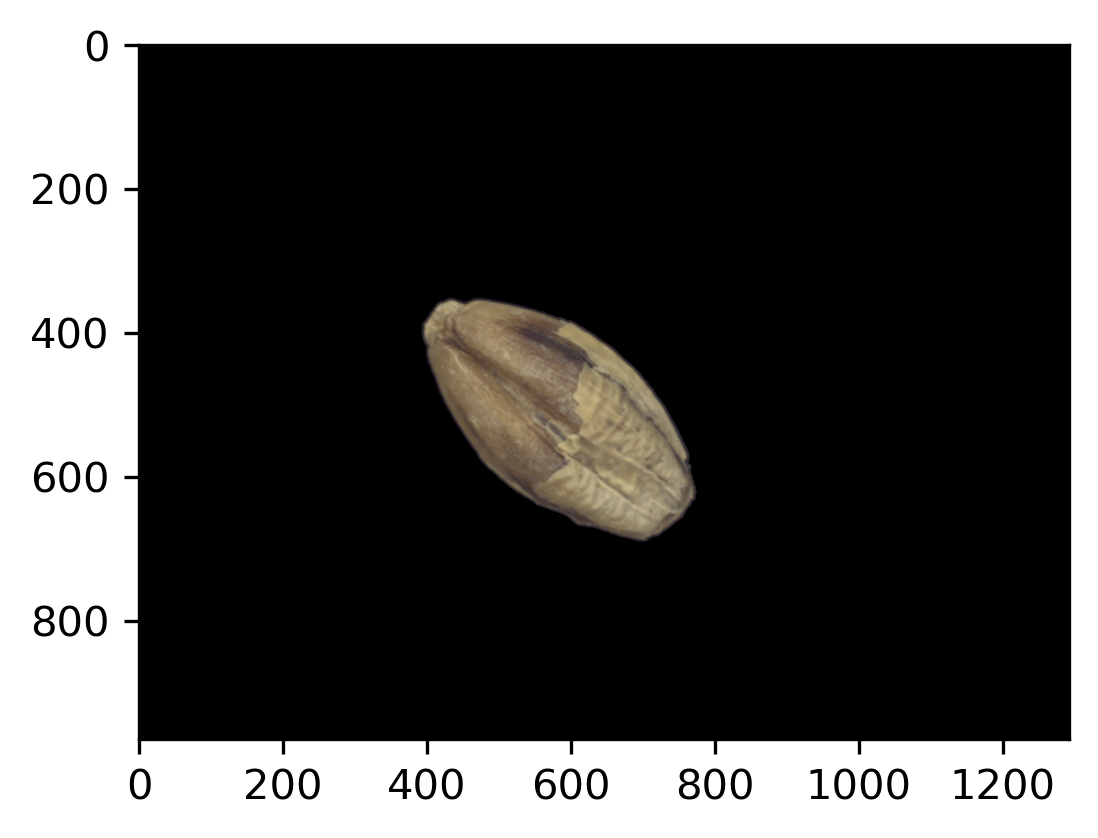

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

def adjust_gamma(image, gamma=1.0):
    # Budowanie tabeli odwzorowań dla wszystkich wartości pikseli od 0 do 255
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")

    # Zastosowanie tabeli odwzorowań do obrazu
    return cv2.LUT(image, table)

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_src, cmap='gray')
    plt.show()

def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold_image(gray):
    # Zastosowanie progowania Otsu
    otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Dostosowanie wartości progowej (np. zmniejszenie progu o 10 jednostek)
    adjusted_threshold = otsu_threshold - 20

    # Zastosowanie dostosowanego progu
    _, binary_image = cv2.threshold(gray, adjusted_threshold, 255, cv2.THRESH_BINARY)    
    return binary_image

def morphology_operations(thresh):
    kernel = np.ones((7, 7), np.uint8)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cv2.dilate(closing, kernel2, iterations=1)

def find_largest_contour(dilated):
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(dilated)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    return mask

def segment_grain(image):
    with Pool(processes=cpu_count()) as pool:
        gray = pool.apply(convert_to_gray, (image,))
        thresh = pool.apply(threshold_image, (gray,))
        dilated = pool.apply(morphology_operations, (thresh,))
        mask = pool.apply(find_largest_contour, (dilated,))

    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

# Załaduj obraz
img_side = cv2.imread('/media/4TB/datasets/DATASET/basil/30564_T.png')

# Segmentacja ziarniaka
segmented = segment_grain(img_side)
gamma_corrected = adjust_gamma(segmented, gamma=1.7)
# Wyświetlenie oryginalnego obrazu i konturu
show(gamma_corrected)

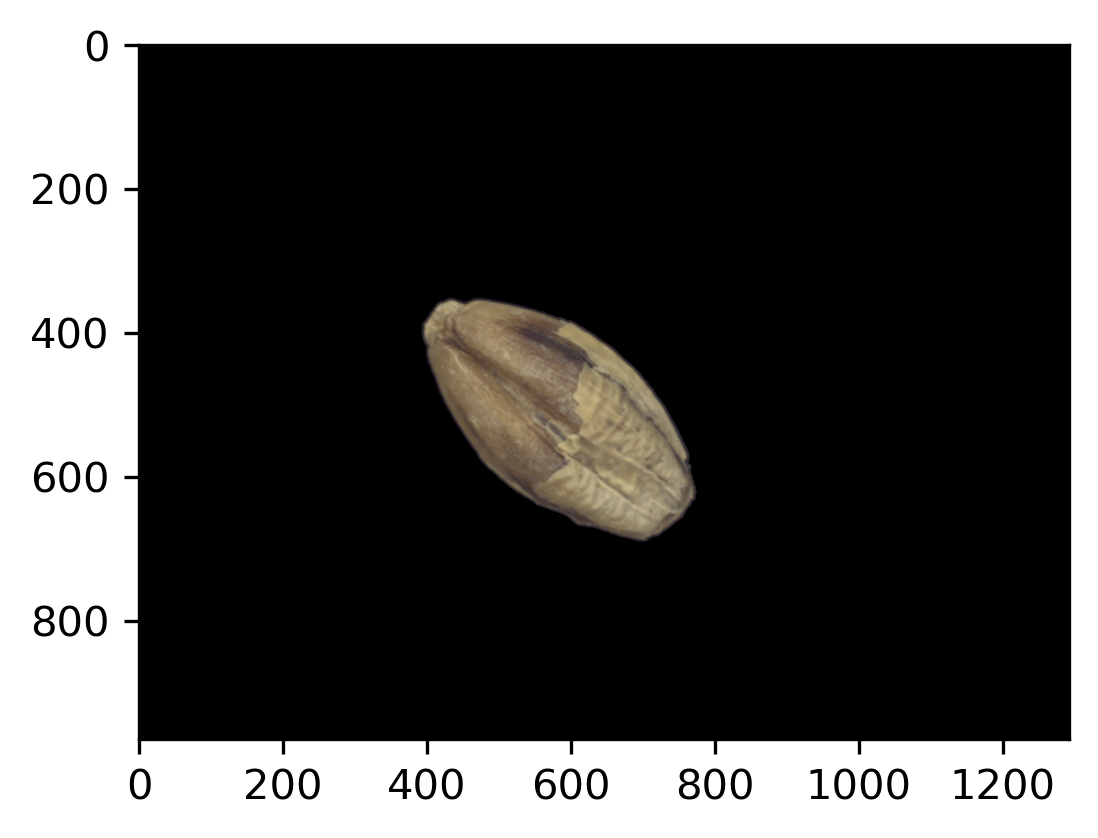

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

def adjust_gamma(image, gamma=1.0):
    # Budowanie tabeli odwzorowań dla wszystkich wartości pikseli od 0 do 255
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")

    # Zastosowanie tabeli odwzorowań do obrazu
    return cv2.LUT(image, table)

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_src, cmap='gray')
    plt.show()

def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold_image(gray):
    # Zastosowanie progowania Otsu
    otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Dostosowanie wartości progowej (np. zmniejszenie progu o 10 jednostek)
    adjusted_threshold = otsu_threshold - 20

    # Zastosowanie dostosowanego progu
    _, binary_image = cv2.threshold(gray, adjusted_threshold, 255, cv2.THRESH_BINARY)    
    return binary_image

def morphology_operations(thresh):
    kernel = np.ones((7, 7), np.uint8)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cv2.dilate(closing, kernel2, iterations=1)

def find_largest_contour(dilated):
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(dilated)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    return mask

def segment_grain(image):
    with Pool(processes=cpu_count()) as pool:
        gray = pool.apply(convert_to_gray, (image,))
        thresh = pool.apply(threshold_image, (gray,))
        dilated = pool.apply(morphology_operations, (thresh,))
        mask = pool.apply(find_largest_contour, (dilated,))

    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented

# Załaduj obraz
img_side = cv2.imread('/media/4TB/datasets/DATASET/basil/30564_T.png')

# Segmentacja ziarniaka
segmented = segment_grain(img_side)
gamma_corrected = adjust_gamma(segmented, gamma=1.7)
# Wyświetlenie oryginalnego obrazu i konturu
show(gamma_corrected)

In [14]:
import cv2
import numpy as np
import os
import glob
import csv
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

def save_image_with_structure(image, original_path, destination_directory):
    """
    Zapisuje obraz w określonej lokalizacji, zachowując jego nazwę i nazwę katalogu nadrzędnego.

    :param image: Obraz do zapisania (numpy array).
    :param original_path: Oryginalna ścieżka do obrazu.
    :param destination_directory: Ścieżka do katalogu docelowego.
    """
    # Pobranie nazwy pliku i katalogu nadrzędnego
    file_name = os.path.basename(original_path)
    parent_dir = os.path.basename(os.path.dirname(original_path))

    # Tworzenie nowej ścieżki do zapisu
    new_dir = os.path.join(destination_directory, parent_dir)
    new_path = os.path.join(new_dir, file_name)

    # Tworzenie katalogu docelowego, jeśli nie istnieje
    os.makedirs(new_dir, exist_ok=True)

    # Zapisywanie obrazu
    cv2.imwrite(new_path, image)
    print(f"Obraz zapisany w: {new_path}")

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    
    print (len(image_src.shape))

    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        print('gray')
        plt.imshow(image_src, cmap='gray')
    plt.show()

def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold_image(gray):
    # Zastosowanie progowania Otsu
    otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Dostosowanie wartości progowej (np. zmniejszenie progu o 10 jednostek)
    adjusted_threshold = otsu_threshold - 20

    # Zastosowanie dostosowanego progu
    _, binary_image = cv2.threshold(gray, adjusted_threshold, 255, cv2.THRESH_BINARY)    
    return binary_image

def morphology_operations(thresh):
    kernel = np.ones((7, 7), np.uint8)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cv2.dilate(closing, kernel2, iterations=1)

def find_largest_contour(dilated):
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def process_image(path_to_image):
    image = cv2.imread(path_to_image)
    gray = convert_to_gray(image)
    thresh = threshold_image(gray)
    dilated = morphology_operations(thresh)
    largest_contour = find_largest_contour(dilated)
    min_ellipse = cv2.fitEllipse(largest_contour)

    if cv2.contourArea(largest_contour) < 1:  # Sprawdzenie, czy kontur nie jest zbyt mały
        return None, None, None, None, None

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    mask_largest_contour = np.zeros_like(gray)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    rotated_image = np.zeros((height, width, 3), dtype=image.dtype)

    for i in range(3):
        rotated_image[:, :, i] = cv2.warpAffine(image[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, path_to_image, os.path.basename(path_to_image)

def process_image_S(path_to_image):
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    gray = image
    thresh = threshold_image(gray)
    dilated = morphology_operations(thresh)
    largest_contour = find_largest_contour(dilated)
    min_ellipse = cv2.fitEllipse(largest_contour)

    if cv2.contourArea(largest_contour) < 1:  # Sprawdzenie, czy kontur nie jest zbyt mały
        return None, None, None, None, None

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    mask_largest_contour = np.zeros_like(gray)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    # Inicjalizacja obrotowego obrazu dla obrazu w odcieniach szarości
    rotated_image = np.zeros((height, width), dtype=image.dtype)

    # Przeprowadzenie obrotu dla obrazu w odcieniach szarości
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height)) * (rotated_mask // 255)

    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, path_to_image, os.path.basename(path_to_image)

def main(directory):
    image_paths = glob.glob(os.path.join(directory, '**', '*.png'), recursive=True)
    total_images = len(image_paths)

    with open('sizes_of_kernels.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Directory', 'Filename', 'Width', 'Height'])

        with ProcessPoolExecutor() as executor:
            futures = {}
            for path in image_paths[:8]:
                if "_S.png" in os.path.basename(path):
                    futures[executor.submit(process_image_S, path)] = path
                else:
                    futures[executor.submit(process_image, path)] = path

            previous_progress = -1

            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                path = futures[future]
                if "_S.png" in os.path.basename(path):
                    show(result)
                else:
                    if result is not None:
                        cropped_image, width, height, dir_name, file_name = result
                        writer.writerow([dir_name, file_name, width, height])
                        show(cropped_image)
                        save_image_with_structure(cropped_image, dir_name, "/media/512GB_ext/preprocesed_dataset")
                current_progress = int(((i + 1) / total_images) * 100)
                if current_progress > previous_progress:
                    print(f'Progress: {current_progress}% {i+1}/{total_images}')
                    previous_progress = current_progress

main("/media/4TB/datasets/DATASET/")


#show(cropped_image)
#save_image_with_structure(cropped_image, dir_name, "/media/512GB_ext/preprocesed_dataset")

AttributeError: 'tuple' object has no attribute 'shape'

<Figure size 1200x1200 with 0 Axes>

In [57]:
import cv2
import numpy as np
import os
import glob
import csv
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

def save_image_with_structure(image, original_path, destination_directory):
    """
    Zapisuje obraz w określonej lokalizacji, zachowując jego nazwę i nazwę katalogu nadrzędnego.

    :param image: Obraz do zapisania (numpy array).
    :param original_path: Oryginalna ścieżka do obrazu.
    :param destination_directory: Ścieżka do katalogu docelowego.
    """
    # Pobranie nazwy pliku i katalogu nadrzędnego
    file_name = os.path.basename(original_path)
    parent_dir = os.path.basename(os.path.dirname(original_path))

    # Tworzenie nowej ścieżki do zapisu
    new_dir = os.path.join(destination_directory, parent_dir)
    new_path = os.path.join(new_dir, file_name)

    # Tworzenie katalogu docelowego, jeśli nie istnieje
    os.makedirs(new_dir, exist_ok=True)

    # Zapisywanie obrazu
    cv2.imwrite(new_path, image)
    #print(f"Obraz zapisany w: {new_path}")

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(num=None, figsize=figsize, dpi=dpi, facecolor='w', edgecolor='k')
    
    print(len(image_src.shape))

    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        print('gray')
        plt.imshow(image_src, cmap='gray')
    plt.show()

def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold_image(gray):
    # Zastosowanie progowania Otsu
    otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Dostosowanie wartości progowej (np. zmniejszenie progu o 10 jednostek)
    adjusted_threshold = otsu_threshold - 20

    # Zastosowanie dostosowanego progu
    _, binary_image = cv2.threshold(gray, adjusted_threshold, 255, cv2.THRESH_BINARY)    
    return binary_image

def morphology_operations(thresh, kernel = (7, 7)):
    
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cv2.dilate(closing, kernel2, iterations=1)

def find_largest_contour(dilated):
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def process_image(path_to_image):
    image = cv2.imread(path_to_image)
    gray = convert_to_gray(image)
    thresh = threshold_image(gray)
    dilated = morphology_operations(thresh)
    largest_contour = find_largest_contour(dilated)
    min_ellipse = cv2.fitEllipse(largest_contour)

    if cv2.contourArea(largest_contour) < 1:  # Sprawdzenie, czy kontur nie jest zbyt mały
        return None, None, None, None, None

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    mask_largest_contour = np.zeros_like(gray)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    rotated_image = np.zeros((height, width, 3), dtype=image.dtype)

    for i in range(3):
        rotated_image[:, :, i] = cv2.warpAffine(image[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, path_to_image, os.path.basename(path_to_image)

def process_image_S(path_to_image):
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    gray = image
    
    # Zastosowanie progowania Otsu, aby uzyskać binarny obraz
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #opcjonalna morfologia
    binary_image = morphology_operations(binary_image)
    
    # Usunięcie dolnej części obrazu, która zawiera odbicie i podłoże
    height, width = binary_image.shape
    binary_image[(height//2) + 15:, :] = 0
    
    # Znajdowanie wszystkich konturów
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:  # Sprawdzenie, czy znaleziono kontury
        return None, None, None, None, None
    
    # Znajdowanie największego konturu (ziarno)
    largest_contour = max(contours, key=cv2.contourArea)
    
    if cv2.contourArea(largest_contour) < 1:  # Sprawdzenie, czy kontur nie jest zbyt mały
        return None, None, None, None, None
    
    # Dopasowanie elipsy do największego konturu
    min_ellipse = cv2.fitEllipse(largest_contour)
    
    # Tworzenie maski dla elipsy

    mask_largest_contour = np.zeros_like(gray)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)

    mask_largest_contour = morphology_operations(mask_largest_contour)
    
    
    # Kadrowanie obrazu do wymiarów eliptycznego obiektu
    x, y, w, h = cv2.boundingRect(mask_largest_contour)
    cropped_image = mask_largest_contour[y:y+h, x:x+w]
    
    # Ustawienie tła na białe
    cropped_image_with_white_background = np.full_like(cropped_image, 0)
    cropped_image_with_white_background[cropped_image != 0] = cropped_image[cropped_image != 0]
    
    return cropped_image_with_white_background, w, h, path_to_image, os.path.basename(path_to_image)

def main(directory):
    image_paths = glob.glob(os.path.join(directory, '**', '*.png'), recursive=True)
    total_images = len(image_paths)

    with open('sizes_of_kernels.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Directory', 'Filename', 'Width', 'Height'])

        with ProcessPoolExecutor() as executor:
            futures = {}
            for path in image_paths[:28]:
                if "_S.png" in os.path.basename(path):
                    futures[executor.submit(process_image_S, path)] = path
                else:
                    futures[executor.submit(process_image, path)] = path

            previous_progress = -1

            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                path = futures[future]
                if "_S.png" in os.path.basename(path):
                    if result is not None:
                        cropped_image, _, _, _, _ = result
                        #show(cropped_image)
                        cropped_image= cv2.rotate(cropped_image, cv2.ROTATE_90_COUNTERCLOCKWISE )
                        save_image_with_structure(cropped_image, path, "/media/512GB_ext/preprocesed_dataset")
                else:
                    if result is not None:
                        
                        cropped_image, width, height, dir_name, file_name = result
                        writer.writerow([dir_name, file_name, width, height])
                        if "_T.png" in os.path.basename(path):
                            cropped_image= cv2.flip(cropped_image,0)
                            
                        #show(cropped_image)
                        save_image_with_structure(cropped_image, dir_name, "/media/512GB_ext/preprocesed_dataset")
                current_progress = int(((i + 1) / total_images) * 100)
                if current_progress > previous_progress:
                    print(f'Progress: {current_progress}% {i+1}/{total_images}')
                    previous_progress = current_progress

main("/media/4TB/datasets/DATASET/")

Progress: 0% 1/346432


In [7]:
import cv2
import numpy as np
import os
import glob
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

def save_image_with_structure(image, original_path, destination_directory):
    file_name = os.path.basename(original_path)
    parent_dir = os.path.basename(os.path.dirname(original_path))
    new_dir = os.path.join(destination_directory, parent_dir)
    new_path = os.path.join(new_dir, file_name)
    os.makedirs(new_dir, exist_ok=True)
    cv2.imwrite(new_path, image)

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_src, cmap='gray')
    plt.show()

def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold_image(gray):
    otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adjusted_threshold = otsu_threshold - 14
    _, binary_image = cv2.threshold(gray, adjusted_threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def morphology_operations(thresh, kernel=(7, 7)):
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cv2.dilate(closing, kernel2, iterations=1)

def find_largest_contour(dilated):
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def process_image(path_to_image):
    image = cv2.imread(path_to_image)
    gray = convert_to_gray(image)
    thresh = threshold_image(gray)
    dilated = morphology_operations(thresh)
    largest_contour = find_largest_contour(dilated)
    min_ellipse = cv2.fitEllipse(largest_contour)

    if cv2.contourArea(largest_contour) < 1:
        return None, None, None, None, None

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    mask_largest_contour = np.zeros_like(gray)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    rotated_image = np.zeros((height, width, 3), dtype=image.dtype)
    for i in range(3):
        rotated_image[:, :, i] = cv2.warpAffine(image[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, path_to_image, os.path.basename(path_to_image)

def process_image_S(path_to_image):
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary_image = morphology_operations(binary_image)

    height, width = binary_image.shape
    binary_image[(height//2) + 15:, :] = 0

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(largest_contour) < 1:
        return None, None, None, None, None

    min_ellipse = cv2.fitEllipse(largest_contour)
    mask_largest_contour = np.zeros_like(image)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    mask_largest_contour = morphology_operations(mask_largest_contour)

    x, y, w, h = cv2.boundingRect(mask_largest_contour)
    cropped_image = mask_largest_contour[y:y+h, x:x+w]
    cropped_image_with_white_background = np.full_like(cropped_image, 0)
    cropped_image_with_white_background[cropped_image != 0] = cropped_image[cropped_image != 0]

    return cropped_image_with_white_background, w, h, path_to_image, os.path.basename(path_to_image)

def main(directory):
    image_paths = glob.glob(os.path.join(directory, '**', '*.png'), recursive=True)
    total_images = len(image_paths)

    with open('sizes_of_kernels.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Directory', 'Filename', 'Width', 'Height'])

        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(process_image_S if "_S.png" in os.path.basename(path) else process_image, path): path for path in image_paths}

            previous_progress = -1
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                path = futures[future]
                if result is not None:
                    cropped_image, width, height, dir_name, file_name = result
                    if "_S.png" in os.path.basename(path):
                        cropped_image = cv2.rotate(cropped_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
                        save_image_with_structure(cropped_image, path, "/media/512GB_ext/preprocesed_dataset")
                    else:
                        writer.writerow([dir_name, file_name, width, height])
                        if "_T.png" in os.path.basename(path):
                            cropped_image = cv2.flip(cropped_image, 0)
                        save_image_with_structure(cropped_image, dir_name, "/media/512GB_ext/preprocesed_dataset")

                current_progress = int(((i + 1) / total_images) * 100)
                if current_progress > previous_progress:
                    print(f'Progress: {current_progress}% {i+1}/{total_images}')
                    previous_progress = current_progress

main("/media/4TB/datasets/DATASET/")

Progress: 0% 1/346432
Progress: 1% 3465/346432
Progress: 2% 6929/346432
Progress: 3% 10393/346432
Progress: 4% 13858/346432
Progress: 5% 17322/346432


In [5]:
import cv2
import numpy as np
import os
import glob
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

def save_image_with_structure(image, original_path, destination_directory):
    file_name = os.path.basename(original_path)
    parent_dir = os.path.basename(os.path.dirname(original_path))
    new_dir = os.path.join(destination_directory, parent_dir)
    new_path = os.path.join(new_dir, file_name)
    os.makedirs(new_dir, exist_ok=True)
    cv2.imwrite(new_path, image)

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_src, cmap='gray')
    plt.show()

def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold_image(gray):
    otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adjusted_threshold = otsu_threshold - 12
    _, binary_image = cv2.threshold(gray, adjusted_threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def morphology_operations(thresh, kernel=(7, 7)):
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cv2.dilate(closing, kernel2, iterations=1)

def find_largest_contour(dilated):
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def process_image(path_to_image):
    image = cv2.imread(path_to_image)
    if image is None:
        return None, None, None, None, None
    gray = convert_to_gray(image)
    thresh = threshold_image(gray)
    dilated = morphology_operations(thresh)
    largest_contour = find_largest_contour(dilated)
    min_ellipse = cv2.fitEllipse(largest_contour)

    if cv2.contourArea(largest_contour) < 1:
        return None, None, None, None, None

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    mask_largest_contour = np.zeros_like(gray)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    rotated_image = np.zeros((height, width, 3), dtype=image.dtype)
    for i in range(3):
        rotated_image[:, :, i] = cv2.warpAffine(image[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, path_to_image, os.path.basename(path_to_image)

def process_image_S(path_to_image):
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None, None, None, None, None
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary_image = morphology_operations(binary_image)

    height, width = binary_image.shape
    binary_image[(height//2) + 15:, :] = 0

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(largest_contour) < 1:
        return None, None, None, None, None

    min_ellipse = cv2.fitEllipse(largest_contour)
    mask_largest_contour = np.zeros_like(image)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    mask_largest_contour = morphology_operations(mask_largest_contour)

    x, y, w, h = cv2.boundingRect(mask_largest_contour)
    cropped_image = mask_largest_contour[y:y+h, x:x+w]
    cropped_image_with_white_background = np.full_like(cropped_image, 0)
    cropped_image_with_white_background[cropped_image != 0] = cropped_image[cropped_image != 0]

    return cropped_image_with_white_background, w, h, path_to_image, os.path.basename(path_to_image)

def main(directory):
    image_paths = glob.glob(os.path.join(directory, '**', '*.png'), recursive=True)
    total_images = len(image_paths)

    with open('sizes_of_kernels.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Directory', 'Filename', 'Width', 'Height'])

        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(process_image_S if "_S.png" in os.path.basename(path) else process_image, path): path for path in image_paths}

            previous_progress = -1
            for i, future in enumerate(as_completed(futures)):
                result = future.result()
                path = futures[future]
                if result is not None:
                    cropped_image, width, height, dir_name, file_name = result
                    if "_S.png" in os.path.basename(path):
                        cropped_image = cv2.rotate(cropped_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
                        save_image_with_structure(cropped_image, path, "/media/512GB_ext/preprocesed_dataset")
                    else:
                        writer.writerow([dir_name, file_name, width, height])
                        if "_T.png" in os.path.basename(path):
                            cropped_image = cv2.flip(cropped_image, 0)
                        save_image_with_structure(cropped_image, dir_name, "/media/512GB_ext/preprocesed_dataset")

                # Explicitly delete variables to free memory
                del result
                del path
                del cropped_image

                current_progress = int(((i + 1) / total_images) * 100)
                if current_progress > previous_progress:
                    print(f'Progress: {current_progress}% {i+1}/{total_images}')
                    previous_progress = current_progress

main("/media/4TB/datasets/DATASET/")

Progress: 0% 1/346432
Progress: 1% 3465/346432
Progress: 2% 6929/346432
Progress: 3% 10393/346432


In [4]:
import cv2
import numpy as np
import os
import glob
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

def save_image_with_structure(image, original_path, destination_directory):
    file_name = os.path.basename(original_path)
    parent_dir = os.path.basename(os.path.dirname(original_path))
    new_dir = os.path.join(destination_directory, parent_dir)
    new_path = os.path.join(new_dir, file_name)
    os.makedirs(new_dir, exist_ok=True)
    cv2.imwrite(new_path, image)

def show(image_src, figsize=(4, 4), dpi=300):
    plt.figure(figsize=figsize, dpi=dpi)
    if len(image_src.shape) == 3:
        plt.imshow(cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_src, cmap='gray')
    plt.show()

def convert_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold_image(gray):
    otsu_threshold, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adjusted_threshold = otsu_threshold - 13
    _, binary_image = cv2.threshold(gray, adjusted_threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def morphology_operations(thresh, kernel=(7, 7), iter = 1):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.dilate(thresh, kernel, iterations=iter)
    thresh = cv2.erode(thresh, kernel, iterations=iter)
    return thresh

def morphology_operations_new(binary_image, kernel_size=(7, 7), iter = 1):
    # Utwórz jądro morfologiczne
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    # Zastosuj operację zamknięcia (closing)
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    # Zastosuj operację erozji, aby wyrównać krawędzie bez zwiększania obrysu konturu
    smoothed_image = cv2.erode(closed_image, kernel, iterations=iter)
    return smoothed_image

def find_largest_contour(dilated):
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def process_image(path_to_image):
    image = cv2.imread(path_to_image)
    if image is None:
        return None, None, None, None, None
    gray = convert_to_gray(image)
    thresh = threshold_image(gray)
    dilated = morphology_operations(thresh,(13, 13), 3)
    largest_contour = find_largest_contour(dilated)
    min_ellipse = cv2.fitEllipse(largest_contour)

    if cv2.contourArea(largest_contour) < 1:
        return None, None, None, None, None

    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    angle = min_ellipse[2]
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    mask_largest_contour = np.zeros_like(gray)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    rotated_mask = cv2.warpAffine(mask_largest_contour, rotation_matrix, (width, height))

    rotated_image = np.zeros((height, width, 3), dtype=image.dtype)
    for i in range(3):
        rotated_image[:, :, i] = cv2.warpAffine(image[:, :, i], rotation_matrix, (width, height)) * (rotated_mask // 255)

    x, y, w, h = cv2.boundingRect(rotated_mask)
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image, w, h, path_to_image, os.path.basename(path_to_image)

def process_image_S_(path_to_image):
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None, None, None, None, None
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary_image = morphology_operations(binary_image)

    height, width = binary_image.shape
    binary_image[(height//2) + 15:, :] = 0

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    if cv2.contourArea(largest_contour) < 1:
        return None, None, None, None, None

    min_ellipse = cv2.fitEllipse(largest_contour)
    mask_largest_contour = np.zeros_like(image)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, thickness=cv2.FILLED)
    mask_largest_contour = morphology_operations(mask_largest_contour)

    x, y, w, h = cv2.boundingRect(mask_largest_contour)
    cropped_image = mask_largest_contour[y:y+h, x:x+w]
    cropped_image_with_white_background = np.full_like(cropped_image, 0)
    cropped_image_with_white_background[cropped_image != 0] = cropped_image[cropped_image != 0]

    return cropped_image_with_white_background, w, h, path_to_image, os.path.basename(path_to_image)

def process_image_S(path_to_image):
    # Wczytaj obraz
    image = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    img_bin = threshold_image(image)
    img_bin = morphology_operations(img_bin,(13, 13), 3)
    #img_bin = find_largest_contour(img_bin)
    
    if img_bin is None:
                raise ValueError("Nie można wczytać obrazu. Sprawdź ścieżkę do pliku.")
            
    # Znajdź pierwszy czarny piksel od góry
    top = 0
    for i in range(img_bin.shape[0]):
        if 0 in img_bin[i, :]:
            top = i
            break
    
    # Znajdź pierwszy biały piksel od dołu
    bottom = img_bin.shape[0]
    for i in range(img_bin.shape[0] - 1, -1, -1):
        if 255 in img_bin[i, :]:
            bottom = i
            break
    #usunięcie czarnego podłoża
    left = 0
    right = img_bin.shape[1]
    img_bin2 = img_bin[top:bottom -33, left:right + 1]

    # Znajdź pierwszy czarny piksel od lewej
    
    left = 0
    for j in range(img_bin2.shape[1]):
        if 0 in img_bin2[:, j]:
            left = j
            break
    # Znajdź pierwszy czarny piksel od prawej
    right = img_bin2.shape[1]
    for j in range(img_bin2.shape[1] - 1, -1, -1):
        if 0 in img_bin2[:, j]:
            right = j
            break
    # Przytnij obraz
    cropped_image = image[top:bottom, left:right + 1]
    cropped_img_bin = img_bin[top:bottom -33, left:right + 1] #WAŻNY PARAMETR - jeżeli kamera się przemieści boczna należy go zamienić
    x, y, w, h = cv2.boundingRect(cropped_image)
    
    return cropped_img_bin, w, h, path_to_image, os.path.basename(path_to_image)

def main(directory, def_img_ext= '*.png', element_start= 0, element_stop = 1000):
    image_paths = glob.glob(os.path.join(directory, '**', def_img_ext), recursive=True)
    total_images = len(image_paths)
    print(f'Total images to processing:{total_images}')

    with open('sizes_of_kernels.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Directory', 'Filename', 'Width', 'Height'])

        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(process_image_S if "_S.png" in os.path.basename(path) else process_image, path): path for path in image_paths[element_start:element_stop]}

            previous_progress = -1
            for i, future in enumerate(as_completed(futures)):
                try:
                    result = future.result()
                    path = futures[future]
                    if result is not None:
                        cropped_image, width, height, dir_name, file_name = result
                        if "_S.png" in os.path.basename(path):
                            cropped_image = cv2.rotate(cropped_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
                            save_image_with_structure(cropped_image, path, "/media/512GB_ext/preprocesed_dataset")
                        else:
                            writer.writerow([dir_name, file_name, width, height])
                            if "_T.png" in os.path.basename(path):
                                cropped_image = cv2.flip(cropped_image, 0)
                            save_image_with_structure(cropped_image, dir_name, "/media/512GB_ext/preprocesed_dataset")

                    # Explicitly delete variables to free memory
                    del result
                    del path
                    del cropped_image

                except Exception as e:
                    print(f"Error processing image {futures[future]}: {e}")

                current_progress = int(((i + 1) / total_images) * 100)
                if current_progress > previous_progress:
                    #print(f'Progress: {current_progress}% {i+1}/{total_images}')
                    previous_progress = current_progress

In [6]:
batch_size = 3500
total = 346432
#batch_size = 100
#total = 100
for i in range(0, int(total/batch_size+1)):
    main("/media/4TB/datasets/DATASET/",'*.png', i*batch_size, i*batch_size+batch_size)
    print(f"Done: {((i*batch_size+batch_size) / total) * 100}%")


Total images to processing:346432
Done: 1.0102992795122854%
Total images to processing:346432
Done: 350001.01029927953%
Total images to processing:346432
Done: 700001.0102992796%
Total images to processing:346432
Done: 1050001.0102992796%
Total images to processing:346432
Done: 1400001.0102992796%
Total images to processing:346432
Done: 1750001.0102992794%
Total images to processing:346432
Done: 2100001.0102992794%
Total images to processing:346432
Done: 2450001.0102992794%
Total images to processing:346432
Done: 2800001.0102992794%
Total images to processing:346432
Done: 3150001.0102992794%
Total images to processing:346432
Done: 3500001.01029928%
Total images to processing:346432
Done: 3850001.01029928%
Total images to processing:346432
Done: 4200001.010299279%
Total images to processing:346432
Done: 4550001.010299279%
Total images to processing:346432
